In [207]:
import pandas as pd
import numpy as np
import pyagrum as gum
import pyagrum.lib.notebook as gnb

# Show all columns
pd.set_option('display.max_columns', None)

# variable information 
vars_df = pd.read_csv('Dataset/processed_credit.csv')
vars_df

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,lt0,Short,Critical account / other credits elsewhere,radio/television,Low,unknown / no savings,ge7 years,4,male: single,none,4,real estate,Old,none,own,2,skilled employee/official,1,yes (registered),yes,Good
1,0to200,Medium,Existing credits paid duly till now,radio/television,Low,lt100 DM,1to4 years,2,female: divorced/separated/married,none,2,real estate,Young,none,own,1,skilled employee/official,1,none,yes,Bad
2,No Checking,Short,Critical account / other credits elsewhere,education,Low,lt100 DM,4to7 years,2,male: single,none,3,real estate,Middle,none,own,1,unskilled - resident,2,none,yes,Good
3,lt0,Medium,Existing credits paid duly till now,furniture/equipment,Medium,lt100 DM,4to7 years,2,male: single,guarantor,4,building society savings / life insurance,Middle,none,for free,1,skilled employee/official,2,none,yes,Good
4,lt0,Short,Delay in paying off in the past,car (new),Low,lt100 DM,1to4 years,3,male: single,none,4,unknown / no property,Middle,none,for free,2,skilled employee/official,2,none,yes,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,No Checking,Short,Existing credits paid duly till now,furniture/equipment,Low,lt100 DM,4to7 years,3,female: divorced/separated/married,none,4,real estate,Young,none,own,1,unskilled - resident,1,none,yes,Good
996,lt0,Medium,Existing credits paid duly till now,car (used),Low,lt100 DM,1to4 years,4,male: divorced/separated,none,4,building society savings / life insurance,Middle,none,own,1,management/self-employed/highly qualified/officer,1,yes (registered),yes,Good
997,No Checking,Short,Existing credits paid duly till now,radio/television,Low,lt100 DM,ge7 years,4,male: single,none,4,car or other,Middle,none,own,1,skilled employee/official,1,none,yes,Good
998,lt0,Medium,Existing credits paid duly till now,radio/television,Low,lt100 DM,1to4 years,4,male: single,none,4,unknown / no property,Young,none,for free,1,skilled employee/official,1,yes (registered),yes,Bad


# Open a saved Bayesian network

In [208]:
import pyagrum.lib.notebook as gnb
import pyagrum as gum

filepath = 'BNs/GermanCreditManual.bif'
bn = gum.loadBN(filepath)
bn

(pyagrum.BayesNet@0000021923DFA0C0) BN{nodes: 26, arcs: 36, domainSize: 10^13.7638, dim: 3736, mem: 55Ko 912o}

Populate random variable values with dataframe column value ranges

In [209]:
# Find observed and unobserved variables
bn_vars = set(bn.names())
df_vars = set(vars_df.columns)
observed_vars = df_vars.intersection(bn_vars)
unobserved_vars = bn_vars - observed_vars
print(f"Observed: {observed_vars}, Unobserved: {unobserved_vars}")
print(len(bn_vars))

Observed: {'CreditHistory', 'CreditAmount', 'InstallmentRate', 'CheckingAccount', 'ExistingCredits', 'Job', 'PersonalStatusSex', 'EmploymentSince', 'Purpose', 'Property', 'OtherDebtors', 'ForeignWorker', 'CreditRisk', 'Housing', 'ResidenceSince', 'Duration', 'OtherInstallmentPlans', 'Age', 'LiablePeople', 'SavingsAccount'}, Unobserved: {'Collateral', 'Capital', 'Capacity', 'Terms', 'Character', 'Income'}
26


In [210]:
def inspect_var_ranges(bn, df=None, sample_rows=5):
	"""Print labels for each variable in the influence diagram and sample uniques from df."""
    # print("Influence diagram variables and labels:")
	mismatches = []
	for var in bn.names():
		try:
			variable = bn.variable(var)
			try:
				labels = list(variable.labels())
			except Exception:
                # fall back to older API
				labels = [str(variable.label(i)) for i in range(variable.domainSize())]
			uniques = df[var].dropna().unique()
			
			if set(labels) != set(uniques):
				# print(f" - {var}: sample_uniques={list(sorted(map(str, uniques)))}")
				# print(f" - {var}: labels={labels}\n")
				print(set(labels), '\n', set(uniques))
				mismatches.append(var)
		except Exception as e:
			pass

	if mismatches:
		return mismatches
	else:
		print("All variable labels match the dataset.")
		return None
    
mismatches = inspect_var_ranges(bn, df=vars_df)
mismatches

{'_4', '_3', '_1', '_2'} 
 {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
{'ge200', 'No_Checking', 'lt0', '_0to200'} 
 {'ge200', 'lt0', '0to200', 'No Checking'}
{'Critical_account__other_credits_elsewhere', 'Delay_in_paying_off_in_the_past', 'No_credits_taken__all_paid_duly', 'Existing_credits_paid_duly_till_now', 'All_credits_at_this_bank_paid_duly'} 
 {'All credits at this bank paid duly', 'Critical account / other credits elsewhere', 'No credits taken / all paid duly', 'Existing credits paid duly till now', 'Delay in paying off in the past'}
{'_4', '_3', '_1', '_2'} 
 {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
{'unskilled__resident', 'management_self_employed_highly_qualified_officer', 'unemployed_unskilled__non_resident', 'skilled_employee_official'} 
 {'skilled employee/official', 'unskilled - resident', 'unemployed/unskilled - non-resident', 'management/self-employed/highly qualified/officer'}
{'male__married_widowed', 'male__single', 'male__divorced_separated', '

['InstallmentRate',
 'CheckingAccount',
 'CreditHistory',
 'ExistingCredits',
 'Job',
 'PersonalStatusSex',
 'EmploymentSince',
 'Purpose',
 'Property',
 'OtherDebtors',
 'Housing',
 'ResidenceSince',
 'LiablePeople',
 'SavingsAccount']

In [211]:
# Filter only unique mismatches
mismatches = set(mismatches)

# Create mapping from dataset values to BN labels
value_to_label = {
    (var, val): label
    for var in mismatches
    for val, label in zip(sorted(vars_df[var].unique()), sorted(bn.variable(var).labels()))
}

# Map dataset values to BN labels in vars_df
for var in mismatches:
    # Convert column to string/object type to avoid dtype issues
    vars_df[var] = vars_df[var].astype(str)

for (var, val), label in value_to_label.items():
    vars_df.loc[vars_df[var] == str(val), var] = str(label)

vars_df.head()

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,lt0,Short,Critical_account__other_credits_elsewhere,radio_television,Low,unknown__no_savings,ge7_years,_4,male__single,none,_4,real_estate,Old,none,own,_2,skilled_employee_official,_1,yes (registered),yes,Good
1,No_Checking,Medium,Existing_credits_paid_duly_till_now,radio_television,Low,lt100_DM,_1to4_years,_2,female__divorced_separated_married,none,_2,real_estate,Young,none,own,_1,skilled_employee_official,_1,none,yes,Bad
2,_0to200,Short,Critical_account__other_credits_elsewhere,education,Low,lt100_DM,_4to7_years,_2,male__single,none,_3,real_estate,Middle,none,own,_1,unskilled__resident,_2,none,yes,Good
3,lt0,Medium,Existing_credits_paid_duly_till_now,furniture_equipment,Medium,lt100_DM,_4to7_years,_2,male__single,guarantor,_4,building_society_savings__life_insurance,Middle,none,for_free,_1,skilled_employee_official,_2,none,yes,Good
4,lt0,Short,Delay_in_paying_off_in_the_past,car_new,Low,lt100_DM,_1to4_years,_3,male__single,none,_4,unknown__no_property,Middle,none,for_free,_2,skilled_employee_official,_2,none,yes,Bad


Note some unobserved variables have been added

In [212]:
def min_conditional_set(bn):
	"""Find the minimal set of variables that d-separate target_var from all other variables."""
	all_vars = set(bn.names())
	
	all_sets = {}
	for var in all_vars:
		min_set = bn.minimalCondSet(var, list(all_vars - {var}))
		all_sets[var] = [bn.variable(i).name() for i in min_set]

	return all_sets

min_sets = min_conditional_set(bn)

# Building probability tables

Truly saw no other way other than parameter learning for a large bayesian network - we maintain the manual structure, with some manual probabilties defined for the unobserved variables

In [213]:
min_sets
unobserved_vars

{'Capacity', 'Capital', 'Character', 'Collateral', 'Income', 'Terms'}

In [214]:
def get_table_probabilities(bn, var_name, vars_df):
    """Get the probabilities for each label of a variable in the BN."""
    counts = vars_df[var_name].value_counts()
    
    # Normalize to probabilities
    probabilities = counts / counts.sum()
    
    # Display the probabilities
    print(probabilities)
    
    # Verify they sum to 1
    print(f"Sum of probabilities: {probabilities.sum()}")
    var = bn.variable(var_name)
    # Print the labels in order
    print(f"Labels for {var_name}:", var.labels())
    
    # Set probabilities by label using dict-style assignment
    p = [float(probabilities[label]) for label in var.labels()]
    print(p)
    bn.cpt(var_name)[{}] = [float(probabilities[label]) for label in var.labels()]
    
    print(f"CPT for {var_name} updated.")

roots = {"ForeignWorker", "Age", "Housing", "Property"}
for var in roots:
    get_table_probabilities(bn, var, vars_df)

Property
car_or_other                                0.332
real_estate                                 0.282
building_society_savings__life_insurance    0.232
unknown__no_property                        0.154
Name: count, dtype: float64
Sum of probabilities: 1.0
Labels for Property: ('building_society_savings__life_insurance', 'car_or_other', 'real_estate', 'unknown__no_property')
[0.232, 0.332, 0.282, 0.154]
CPT for Property updated.
Age
Young     0.656
Middle    0.276
Old       0.068
Name: count, dtype: float64
Sum of probabilities: 1.0
Labels for Age: ('Middle', 'Old', 'Young')
[0.276, 0.068, 0.656]
CPT for Age updated.
Housing
own         0.713
rent        0.179
for_free    0.108
Name: count, dtype: float64
Sum of probabilities: 0.9999999999999999
Labels for Housing: ('for_free', 'own', 'rent')
[0.108, 0.713, 0.179]
CPT for Housing updated.
ForeignWorker
yes    0.963
no     0.037
Name: count, dtype: float64
Sum of probabilities: 1.0
Labels for ForeignWorker: ('no', 'yes')
[0.037, 0

{'Capacity', 'Capital', 'Character', 'Collateral', 'Income', 'Terms'}

In [215]:
for var in unobserved_vars:
    print(f'{var}: {list(bn.variable(var).labels())}')

Collateral: ['none', 'some', 'good']
Capital: ['low', 'medium', 'high']
Capacity: ['low', 'medium', 'high']
Terms: ['short', 'medium', 'long']
Character: ['bad', 'good']
Income: ['low', 'medium', 'high']


In [216]:
# Augment vars_df with unobserved variables (random values from BN labels)
unobs_seed = 42
np.random.seed(unobs_seed)

# Custom probabilities for unobserved variables
custom_probs = {
    "Collateral": [0.7, 0.2, 0.1],  
    "Capital": [0.7, 0.2, 0.1],
	"Capacity": [0.3, 0.4, 0.3],
	"Terms": [0.2, 0.35, 0.45],
	"Character": [0.22, 0.78],
	"Income": [0.1, 0.3, 0.6]
    
}

for var in unobserved_vars:
    labels = list(bn.variable(var).labels())
    probs = custom_probs.get(var, None)
    if probs is not None and len(probs) == len(labels):
        # Note use of np.random.choice with specified probabilities
        vars_df[var] = np.random.choice(labels, size=len(vars_df), p=probs)
    else:
        # Fall back to uniform if no custom probs provided or length mismatch
        vars_df[var] = np.random.choice(labels, size=len(vars_df))
    print(f"Added column '{var}' with random values from {labels}")

print(f"Augmented DataFrame shape: {vars_df.shape}")
vars_df.head()

Added column 'Collateral' with random values from ['none', 'some', 'good']
Added column 'Capital' with random values from ['low', 'medium', 'high']
Added column 'Capacity' with random values from ['low', 'medium', 'high']
Added column 'Terms' with random values from ['short', 'medium', 'long']
Added column 'Character' with random values from ['bad', 'good']
Added column 'Income' with random values from ['low', 'medium', 'high']
Augmented DataFrame shape: (1000, 27)


,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk,Collateral,Capital,Capacity,Terms,Character,Income
0,lt0,Short,Critical_account__other_credits_elsewhere,radio_television,Low,unknown__no_savings,ge7_years,_4,male__single,none,_4,real_estate,Old,none,own,_2,skilled_employee_official,_1,yes (registered),yes,Good,none,low,low,long,good,medium
1,No_Checking,Medium,Existing_credits_paid_duly_till_now,radio_television,Low,lt100_DM,_1to4_years,_2,female__divorced_separated_married,none,_2,real_estate,Young,none,own,_1,skilled_employee_official,_1,none,yes,Bad,good,low,low,long,good,high
2,_0to200,Short,Critical_account__other_credits_elsewhere,education,Low,lt100_DM,_4to7_years,_2,male__single,none,_3,real_estate,Middle,none,own,_1,unskilled__resident,_2,none,yes,Good,some,medium,high,medium,good,high
3,lt0,Medium,Existing_credits_paid_duly_till_now,furniture_equipment,Medium,lt100_DM,_4to7_years,_2,male__single,guarantor,_4,building_society_savings__life_insurance,Middle,none,for_free,_1,skilled_employee_official,_2,none,yes,Good,none,medium,low,long,bad,medium
4,lt0,Short,Delay_in_paying_off_in_the_past,car_new,Low,lt100_DM,_1to4_years,_3,male__single,none,_4,unknown__no_property,Middle,none,for_free,_2,skilled_employee_official,_2,none,yes,Bad,none,medium,low,long,bad,high


In [217]:
# Variable in dataset but not in BN - not very useful

print(set(vars_df.columns) - bn_vars)

{'Telephone'}


BN names (sorted): ['Age', 'Capacity', 'Capital', 'Character', 'CheckingAccount', 'Collateral', 'CreditAmount', 'CreditHistory', 'CreditRisk', 'Duration', 'EmploymentSince', 'ExistingCredits', 'ForeignWorker', 'Housing', 'Income', 'InstallmentRate', 'Job', 'LiablePeople', 'OtherDebtors', 'OtherInstallmentPlans', 'PersonalStatusSex', 'Property', 'Purpose', 'ResidenceSince', 'SavingsAccount', 'Terms']
DF columns (sorted): ['Age', 'Capacity', 'Capital', 'Character', 'CheckingAccount', 'Collateral', 'CreditAmount', 'CreditHistory', 'CreditRisk', 'Duration', 'EmploymentSince', 'ExistingCredits', 'ForeignWorker', 'Housing', 'Income', 'InstallmentRate', 'Job', 'LiablePeople', 'OtherDebtors', 'OtherInstallmentPlans', 'PersonalStatusSex', 'Property', 'Purpose', 'ResidenceSince', 'SavingsAccount', 'Terms']
Match? True
DataFrame shape after dropna: (1000, 26)


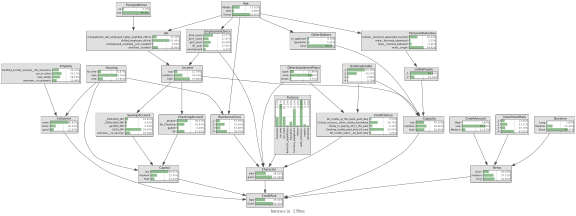

In [218]:
# Before learning, filter vars_df to only BN variables
vars_df = vars_df[list(bn_vars)]

# Check if names match
print("BN names (sorted):", sorted(bn.names()))
print("DF columns (sorted):", sorted(vars_df.columns))
print("Match?", set(bn.names()) == set(vars_df.columns))

# Drop rows with NaN (BNLearner can't handle missing data)
vars_df = vars_df.dropna()
print(f"DataFrame shape after dropna: {vars_df.shape}")

# Learn parameters from the data - maintain predefined structure
learner = gum.BNLearner(vars_df, bn)

# Joint observations require us to use some form of smoothing to avoid zero probabilities
learner.useSmoothingPrior()  # Default weight=1.0; adds uniform prior to all CPT entries

learned_bn = learner.fitParameters(bn)

# Inference
gnb.showInference(bn)

bn.saveBIF('BNs/GermanCreditLearned.bif')

# Creating Influence diagram


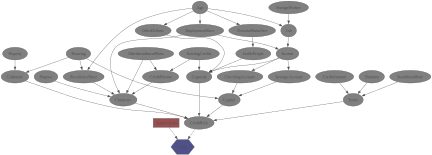

In [219]:
# Load the influnce diagram

influence_diagram = gum.loadID('credit_id.xml')
gnb.showInfluenceDiagram(influence_diagram)

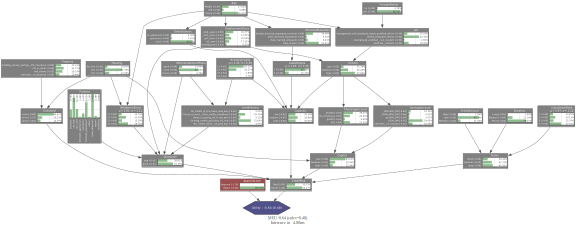

In [ ]:
gnb.showInference(influence_diagram)

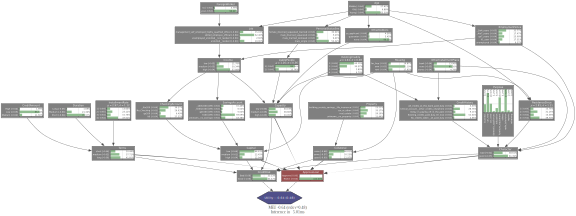

In [227]:
# Add the parents of credit risk to the action node

parents = bn.parents("CreditRisk")
decision_name = "ApproveLoan"

for parent in parents:
    parent_name = bn.variable(parent).name()
    influence_diagram.addArc(parent_name, decision_name)

gnb.showInference(influence_diagram)